## Optimization Two - Project Two

In [9]:
# pip install seaborn

In [7]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

def airline_dp_solution(max_coach_overbooking):
    """
    Solve the airline ticket pricing problem using dynamic programming,
    with corrected transition probability calculations and fixed visualizations.
    Enforces high price for first class when it's sold out.
    
    If max_coach_overbooking is a singular integer, it solves for that value.
    If it is an iterable (e.g., list or range), it loops over each value,
    stores the results in a dictionary, and plots the expected DP profit vs. overbooking level.
    
    Returns a dictionary containing:
      - 'results': DP results for each overbooking level (if a range was provided) or for the single value.
      - 'plot' (if a range is provided): A matplotlib figure showing expected profit vs. overbooking.
    """
    
    def dp_for_single_value(ob_value):
        # Parameters
        coach_seats = 100
        first_class_seats = 20
        max_coach_tickets = coach_seats + ob_value  
        days_until_takeoff = 365

        # Pricing options
        coach_prices = [300, 350]
        first_class_prices = [425, 500]

        # Sale probabilities
        coach_sale_prob = {300: 0.65, 350: 0.30}
        coach_sale_prob_fc_sold_out = {300: 0.68, 350: 0.33}
        first_class_sale_prob = {425: 0.08, 500: 0.04}

        # Show-up probabilities
        coach_show_prob = 0.95
        first_class_show_prob = 0.97

        # Overbooking costs
        cost_bump_to_first_class = 50
        cost_bump_off_plane = 425

        # Discount rate
        annual_discount_rate = 0.17
        daily_discount_factor = 1 / (1 + annual_discount_rate / 365)
        
        # Print the discount factor for debugging.
        # print(f"Daily discount factor: {daily_discount_factor}")

        # Initialize state values and policy arrays
        V = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1))
        policy = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1), dtype=int)

        # Terminal day cost: calculate expected overbooking costs (day 365)
        for coach_sold in range(max_coach_tickets + 1):
            for fc_sold in range(first_class_seats + 1):
                cost = 0
                # Loop over all possible show-up combinations using the binomial distribution.
                for coach_show in range(coach_sold + 1):
                    coach_prob = binom.pmf(coach_show, coach_sold, coach_show_prob)
                    for fc_show in range(fc_sold + 1):
                        fc_prob = binom.pmf(fc_show, fc_sold, first_class_show_prob)
                        scenario_prob = coach_prob * fc_prob
                        if coach_show > coach_seats:
                            bumped = coach_show - coach_seats
                            available_fc = max(0, first_class_seats - fc_show)
                            bumped_to_fc = min(bumped, available_fc)
                            bumped_off = bumped - bumped_to_fc
                            scenario_cost = (bumped_to_fc * cost_bump_to_first_class) + (bumped_off * cost_bump_off_plane)
                            cost += scenario_prob * scenario_cost
                V[coach_sold, fc_sold, -1] = -cost  # Negative because cost reduces value

        # Backward induction
        for day in range(days_until_takeoff - 1, -1, -1):
            for coach_sold in range(max_coach_tickets + 1):
                for fc_sold in range(first_class_seats + 1):
                    # Skip impossible states.
                    if coach_sold > max_coach_tickets or fc_sold > first_class_seats:
                        continue
                    # When first class is full, force high price for first class.
                    if fc_sold == first_class_seats:
                        best_value = float('-inf')
                        best_action = -1
                        for c_idx, coach_price in enumerate(coach_prices):
                            action = c_idx * 2 + 1  # fc index forced to 1;
                            coach_available = coach_sold < max_coach_tickets
                            expected_revenue = 0
                            if coach_available:
                                c_prob = coach_sale_prob_fc_sold_out[coach_price]
                                expected_revenue += c_prob * coach_price
                            if not coach_available:
                                expected_future_value = V[coach_sold, fc_sold, day + 1]
                            else:
                                prob_no_sale = 1 - c_prob
                                expected_future_value = (prob_no_sale * V[coach_sold, fc_sold, day + 1] +
                                                         c_prob * V[coach_sold + 1, fc_sold, day + 1])
                            current_value = expected_revenue + daily_discount_factor * expected_future_value
                            if current_value > best_value:
                                best_value = current_value
                                best_action = action
                        V[coach_sold, fc_sold, day] = best_value
                        policy[coach_sold, fc_sold, day] = best_action
                    else:
                        best_value = float('-inf')
                        best_action = 0
                        coach_available = coach_sold < max_coach_tickets
                        fc_available = fc_sold < first_class_seats
                        if not coach_available and not fc_available:
                            V[coach_sold, fc_sold, day] = daily_discount_factor * V[coach_sold, fc_sold, day + 1]
                            continue
                        for c_idx, coach_price in enumerate(coach_prices):
                            for f_idx, fc_price in enumerate(first_class_prices):
                                action = c_idx * 2 + f_idx
                                c_prob = (coach_sale_prob_fc_sold_out[coach_price]
                                          if (fc_sold == first_class_seats and coach_available)
                                          else (coach_sale_prob[coach_price] if coach_available else 0))
                                f_prob = first_class_sale_prob[fc_price] if fc_available else 0
                                expected_revenue = (coach_price * c_prob if coach_available else 0) + \
                                                   (fc_price * f_prob if fc_available else 0)
                                expected_future_value = 0
                                # Neither sells:
                                prob_neither = (1 - c_prob if coach_available else 1) * (1 - f_prob if fc_available else 1)
                                expected_future_value += prob_neither * V[coach_sold, fc_sold, day + 1]
                                # Only coach sells:
                                if coach_available:
                                    prob_only_coach = c_prob * (1 - f_prob if fc_available else 1)
                                    expected_future_value += prob_only_coach * V[coach_sold + 1, fc_sold, day + 1]
                                # Only first class sells:
                                if fc_available:
                                    prob_only_fc = (1 - c_prob if coach_available else 1) * f_prob
                                    expected_future_value += prob_only_fc * V[coach_sold, fc_sold + 1, day + 1]
                                # Both sell:
                                if coach_available and fc_available:
                                    prob_both = c_prob * f_prob
                                    expected_future_value += prob_both * V[coach_sold + 1, fc_sold + 1, day + 1]
                                current_value = expected_revenue + daily_discount_factor * expected_future_value
                                if current_value > best_value:
                                    best_value = current_value
                                    best_action = action
                        V[coach_sold, fc_sold, day] = best_value
                        policy[coach_sold, fc_sold, day] = best_action
        return V, policy, daily_discount_factor, coach_seats, first_class_seats, max_coach_tickets, days_until_takeoff, coach_prices, first_class_prices

    # If a single integer is provided, solve for that value
    if isinstance(max_coach_overbooking, int):
        V, policy, daily_discount_factor, coach_seats, first_class_seats, max_coach_tickets, days_until_takeoff, coach_prices, first_class_prices = dp_for_single_value(max_coach_overbooking)
        # Create visualizations
        def create_fixed_visualizations(policy):
            print("Creating fixed visualizations...")
            def get_prices(action):
                coach_idx = action // 2
                fc_idx = action % 2
                return coach_prices[coach_idx], first_class_prices[fc_idx]
            days_to_check = np.linspace(0, days_until_takeoff-1, 15, dtype=int)
            coach_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0, 1.05]
            fc_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0]
            coach_price_data = np.zeros((len(coach_fill_levels), len(days_to_check)))
            fc_price_data = np.zeros((len(fc_fill_levels), len(days_to_check)))
            for i, fill_level in enumerate(coach_fill_levels):
                coach_sold = min(int(fill_level * coach_seats), max_coach_tickets)
                fc_sold = 0
                for j, day in enumerate(days_to_check):
                    action = policy[coach_sold, fc_sold, day]
                    coach_price, _ = get_prices(action)
                    coach_price_data[i, j] = coach_price
            for i, fill_level in enumerate(fc_fill_levels):
                fc_sold = min(int(fill_level * first_class_seats), first_class_seats)
                coach_sold = 0
                for j, day in enumerate(days_to_check):
                    action = policy[coach_sold, fc_sold, day]
                    _, fc_price = get_prices(action)
                    fc_price_data[i, j] = fc_price
            plt.figure(figsize=(14, 8))
            for i, fill_level in enumerate(coach_fill_levels):
                plt.plot(days_to_check, coach_price_data[i], 'o-', 
                         label=f"{int(fill_level*100)}% Coach Filled ({int(fill_level*coach_seats)} seats)")
            plt.xlabel('Days Since Start')
            plt.ylabel('Optimal Coach Price ($)')
            plt.title('Coach Price Evolution')
            plt.legend()
            plt.grid(True)
            plt.show()

            plt.figure(figsize=(14, 8))
            for i, fill_level in enumerate(fc_fill_levels):
                plt.plot(days_to_check, fc_price_data[i], 's-', 
                         label=f"{int(fill_level*100)}% First Class Filled ({int(fill_level*first_class_seats)} seats)")
            plt.xlabel('Days Since Start')
            plt.ylabel('Optimal First Class Price ($)')
            plt.title('First Class Price Evolution')
            plt.legend()
            plt.grid(True)
            plt.show()
        create_fixed_visualizations(policy)
        print(f"Final Expected Discounted Profit: ${V[0,0,0]:.2f}")
        return {'expected_profit': V[0,0,0], 'value_function': V, 'policy': policy}
    
    else:
        # Assume max_coach_overbooking is an iterable (range or list)
        results = {}
        expected_profits = []
        for ob in max_coach_overbooking:
            print(f"\nSolving DP for overbooking level: {ob}")
            V, policy, daily_discount_factor, coach_seats, first_class_seats, max_coach_tickets, days_until_takeoff, coach_prices, first_class_prices = dp_for_single_value(ob)
            results[ob] = {'expected_profit': V[0,0,0], 'value_function': V, 'policy': policy}
            expected_profits.append(V[0,0,0])
        # Create a plot of expected profit vs. overbooking level
        plt.figure(figsize=(10,6))
        plt.plot(list(max_coach_overbooking), expected_profits, marker='o')
        plt.xlabel('Max Coach Overbooking')
        plt.ylabel('Expected Discounted Profit')
        plt.title('DP Expected Profit vs. Max Coach Overbooking')
        plt.grid(True)
        plt.show()
        return {'results': results, 'expected_profit_plot': plt.gcf()}

#### Question One - 5 Coach Overbooking

Creating fixed visualizations...


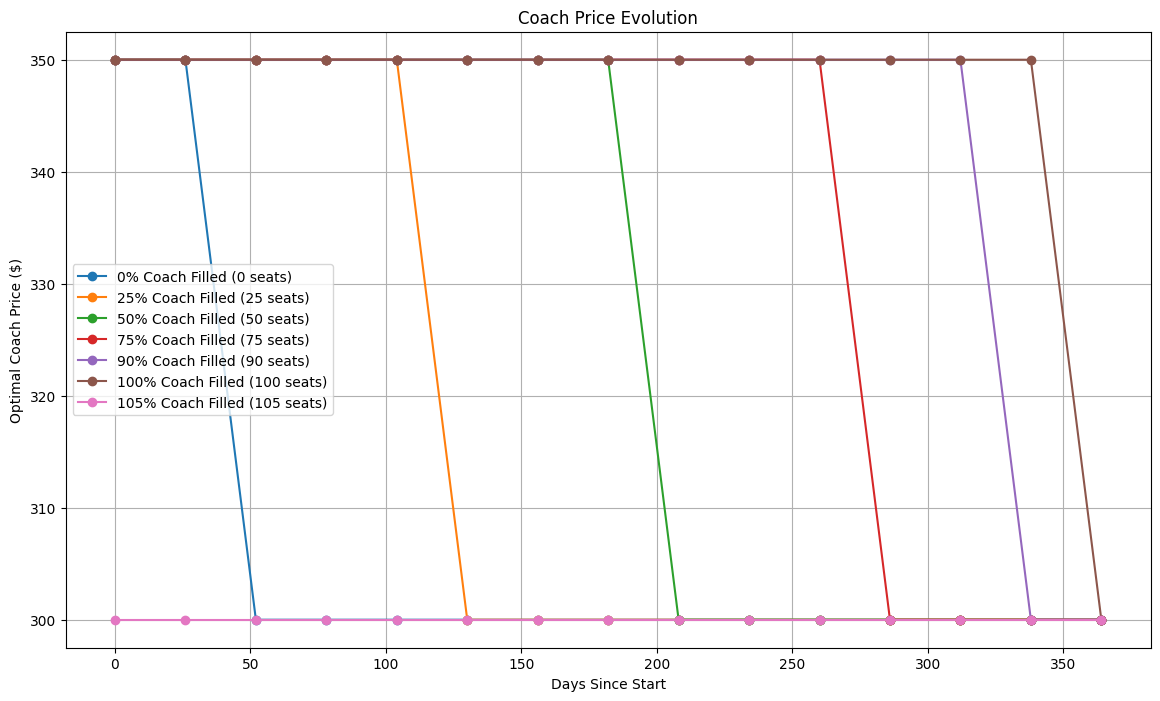

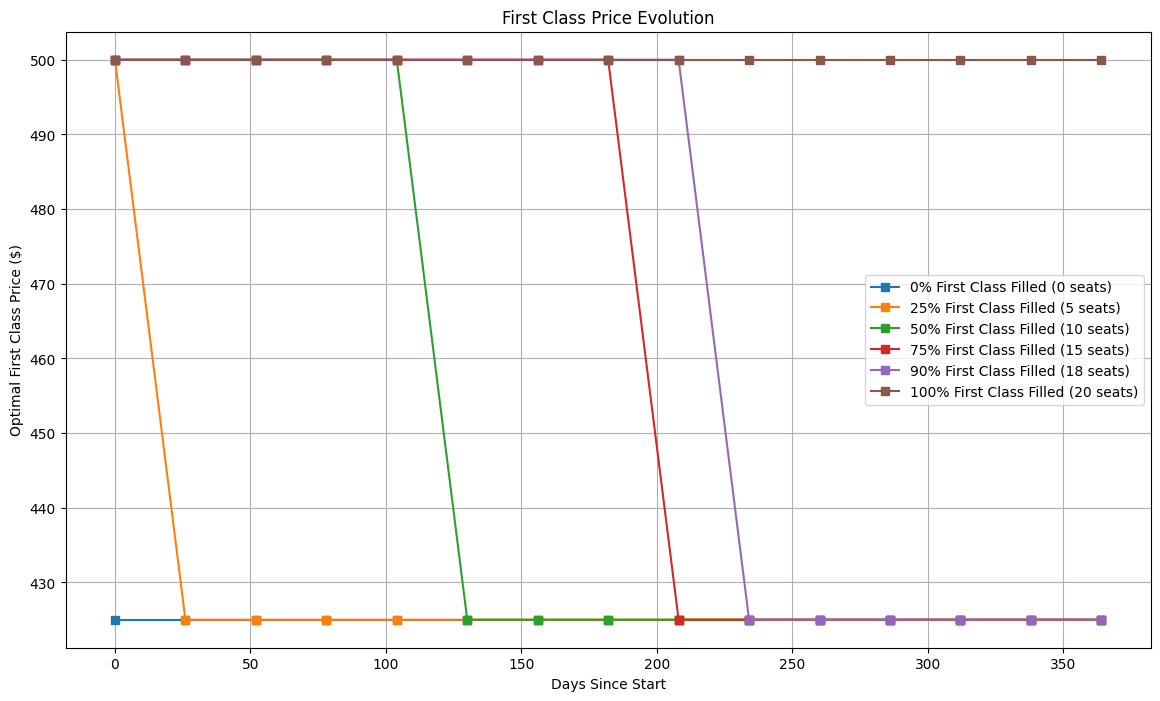

Final Expected Discounted Profit: $41886.16


In [8]:
# To solve for a single overbooking level:
result_single = airline_dp_solution(5)

#### Question Two - 6 through 15 coach overbookings


Solving DP for overbooking level: 5

Solving DP for overbooking level: 6

Solving DP for overbooking level: 7

Solving DP for overbooking level: 8

Solving DP for overbooking level: 9

Solving DP for overbooking level: 10

Solving DP for overbooking level: 11

Solving DP for overbooking level: 12

Solving DP for overbooking level: 13

Solving DP for overbooking level: 14

Solving DP for overbooking level: 15


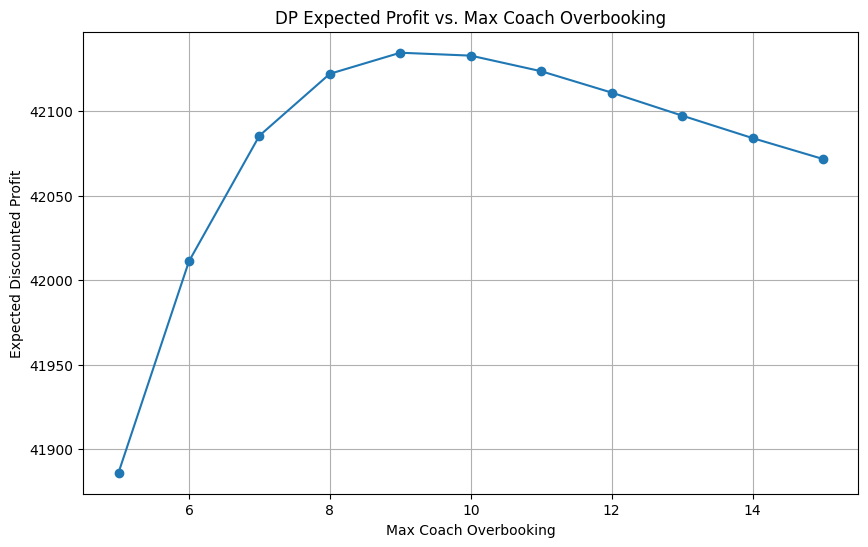


DP Expected Profit for Different Overbooking Levels:
    Expected Profit
5      41886.158624
6      42011.221060
7      42085.536156
8      42122.167269
9      42134.624830
10     42132.900382
11     42123.665936
12     42111.029670
13     42097.419510
14     42084.111570
15     42071.742309


<Figure size 640x480 with 0 Axes>

In [10]:
# Solve for a range of overbooking levels:
result_range = airline_dp_solution(range(5, 16))
df_results = pd.DataFrame({ob: {'Expected Profit': res['expected_profit']} for ob, res in result_range['results'].items()}).T
print("\nDP Expected Profit for Different Overbooking Levels:")
print(df_results)

9 overbookings looks to be the best solution here with an expected profit of $42,134.62

#### Question Three - High Price, Low Price, No Sale

In [ ]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

def airline_dp_solution():
    """
    Solve the airline ticket pricing problem using dynamic programming,
    now allowing the airline to choose to sell no coach tickets on a day.
    
    Coach has three options each day:
      0: No sale (force demand = 0)
      1: Low price
      2: High price
      
    First class has two options:
      0: Low price
      1: High price
      
    The overall daily action is encoded as: action = (coach_option)*2 + (fc_option).
    (If first class is full, we force fc option = 1.)
    
    The airline never sells more than 120 coach tickets (fixed).
    
    Returns a dictionary with the DP solution (expected profit, value function, and policy).
    """
    
    def dp_for_single_value():
        # Parameters
        coach_seats = 100
        first_class_seats = 20
        # Maximum coach tickets fixed at 120.
        max_coach_tickets = 120  
        days_until_takeoff = 365

        # Pricing options
        coach_prices = [300, 350]      # low and high price for coach
        first_class_prices = [425, 500]  # low and high price for first class

        # Sale probabilities for coach
        coach_sale_prob = {300: 0.65, 350: 0.30}
        coach_sale_prob_fc_sold_out = {300: 0.68, 350: 0.33}
        # Sale probabilities for first class
        first_class_sale_prob = {425: 0.08, 500: 0.04}

        # Show-up probabilities (no-show)
        coach_show_prob = 0.95
        first_class_show_prob = 0.97

        # Overbooking costs (applied at terminal day)
        cost_bump_to_first_class = 50
        cost_bump_off_plane = 425

        # Discount rate
        annual_discount_rate = 0.17
        daily_discount_factor = 1 / (1 + annual_discount_rate / 365)

        # Initialize value function and policy arrays:
        V = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1))
        policy = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1), dtype=int)

        # Terminal day cost: compute expected overbooking cost at day = days_until_takeoff.
        for cs in range(max_coach_tickets + 1):
            for fs in range(first_class_seats + 1):
                cost = 0
                for coach_show in range(cs + 1):
                    coach_prob = binom.pmf(coach_show, cs, coach_show_prob)
                    for fc_show in range(fs + 1):
                        fc_prob = binom.pmf(fc_show, fs, first_class_show_prob)
                        scenario_prob = coach_prob * fc_prob
                        if coach_show > coach_seats:
                            bumped = coach_show - coach_seats
                            available_fc = max(0, first_class_seats - fc_show)
                            bumped_to_fc = min(bumped, available_fc)
                            bumped_off = bumped - bumped_to_fc
                            scenario_cost = (bumped_to_fc * cost_bump_to_first_class) + (bumped_off * cost_bump_off_plane)
                            cost += scenario_prob * scenario_cost
                V[cs, fs, -1] = -cost  # Terminal value

        # Backward induction:
        # New action space: Coach has 3 options (0: no sale, 1: low, 2: high),
        # First class has 2 options (0: low, 1: high).
        # Overall action = coach_option*2 + fc_option.
        for day in range(days_until_takeoff - 1, -1, -1):
            for cs in range(max_coach_tickets + 1):
                for fs in range(first_class_seats + 1):
                    # If first class is full, force fc_option = 1.
                    if fs == first_class_seats:
                        allowed_actions = [0*2 + 1, 1*2 + 1, 2*2 + 1]  # actions: 1, 3, 5.
                    else:
                        allowed_actions = range(6)  # actions 0 through 5.
                    
                    best_value = float('-inf')
                    best_action = None
                    for action in allowed_actions:
                        coach_option = action // 2  # 0, 1, or 2
                        fc_option = action % 2        # 0 or 1

                        # Coach: if coach_option == 0 then no sale.
                        if coach_option == 0:
                            p_c = 0
                            rev_coach = 0
                        else:
                            price_coach = coach_prices[coach_option - 1]
                            if cs < max_coach_tickets:
                                if fs == first_class_seats:
                                    p_c = coach_sale_prob_fc_sold_out[price_coach]
                                else:
                                    p_c = coach_sale_prob[price_coach]
                            else:
                                p_c = 0
                            rev_coach = price_coach * p_c

                        # First class: if fs == first_class_seats, force high price.
                        if fs == first_class_seats:
                            price_fc = first_class_prices[1]
                            p_f = 0  # no new sale possible when full.
                        else:
                            price_fc = first_class_prices[fc_option]
                            p_f = first_class_sale_prob[price_fc]
                        rev_fc = price_fc * p_f if fs < first_class_seats else 0

                        immediate_revenue = rev_coach + rev_fc

                        # Transition probabilities.
                        prob_none = (1 - p_c) * (1 - p_f)
                        prob_coach_only = p_c * (1 - p_f) if cs < max_coach_tickets else 0
                        prob_fc_only = (1 - p_c) * p_f if fs < first_class_seats else 0
                        prob_both = p_c * p_f if (cs < max_coach_tickets and fs < first_class_seats) else 0

                        future_value = 0
                        future_value += prob_none * V[cs, fs, day+1]
                        if cs < max_coach_tickets:
                            future_value += prob_coach_only * V[cs+1, fs, day+1]
                        if fs < first_class_seats:
                            future_value += prob_fc_only * V[cs, fs+1, day+1]
                        if cs < max_coach_tickets and fs < first_class_seats:
                            future_value += prob_both * V[cs+1, fs+1, day+1]

                        current_value = immediate_revenue + daily_discount_factor * future_value

                        if current_value > best_value:
                            best_value = current_value
                            best_action = action
                    V[cs, fs, day] = best_value
                    policy[cs, fs, day] = best_action
        return V, policy, daily_discount_factor, coach_seats, first_class_seats, max_coach_tickets, days_until_takeoff, coach_prices, first_class_prices

    # Run the DP for the fixed maximum of 120 coach tickets.
    V, policy, daily_discount_factor, coach_seats, first_class_seats, max_coach_tickets, days_until_takeoff, coach_prices, first_class_prices = dp_for_single_value()

    def create_fixed_visualizations(policy):
        print("Creating fixed visualizations for pricing evolution...")
        def get_prices(action):
            coach_option = action // 2
            fc_option = action % 2
            # For coach, if no sale is chosen, set to NaN.
            if coach_option == 0:
                price_coach = np.nan
            else:
                price_coach = coach_prices[coach_option - 1]
            # For first class, if first class is full, force high price.
            price_fc = first_class_prices[fc_option] if fc_option in [0,1] else first_class_prices[1]
            return price_coach, price_fc

        days_to_check = np.linspace(0, days_until_takeoff-1, 15, dtype=int)
        coach_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0, 1.05]
        fc_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0]
            
        coach_price_data = np.zeros((len(coach_fill_levels), len(days_to_check)))
        fc_price_data = np.zeros((len(fc_fill_levels), len(days_to_check)))
            
        for i, fill in enumerate(coach_fill_levels):
            cs = min(int(fill * coach_seats), max_coach_tickets)
            fs = 0
            for j, day in enumerate(days_to_check):
                act = policy[cs, fs, day]
                price_coach, _ = get_prices(act)
                coach_price_data[i, j] = price_coach
        for i, fill in enumerate(fc_fill_levels):
            fs = min(int(fill * first_class_seats), first_class_seats)
            cs = 0
            for j, day in enumerate(days_to_check):
                act = policy[cs, fs, day]
                _, price_fc = get_prices(act)
                fc_price_data[i, j] = price_fc
            
        plt.figure(figsize=(14, 8))
        for i, fill in enumerate(coach_fill_levels):
            plt.plot(days_to_check, coach_price_data[i], 'o-', label=f"{int(fill*100)}% Coach Filled")
        plt.xlabel('Days Since Start')
        plt.ylabel('Optimal Coach Price ($)')
        plt.title('Coach Price Evolution (DP)')
        plt.legend()
        plt.grid(True)
        plt.show()
            
        plt.figure(figsize=(14, 8))
        for i, fill in enumerate(fc_fill_levels):
            plt.plot(days_to_check, fc_price_data[i], 's-', label=f"{int(fill*100)}% First Class Filled")
        plt.xlabel('Days Since Start')
        plt.ylabel('Optimal First Class Price ($)')
        plt.title('First Class Price Evolution (DP)')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    create_fixed_visualizations(policy)
    print(f"Final Expected Discounted Profit: ${V[0,0,0]:.2f}")
    return {'expected_profit': V[0,0,0], 'value_function': V, 'policy': policy}

#----------------------------------------------------------#
# Solve for the fixed maximum of 120 coach tickets.
result_single = airline_dp_solution()

#### Question 4 - Introduce variable demand (Demand increased as t gets closer to T)

In [ ]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

def airline_dp_solution():
    """
    Solve the airline ticket pricing problem using dynamic programming,
    now allowing the airline to choose to sell no coach tickets on a day.
    
    Coach has three options each day:
      0: No sale (force demand = 0)
      1: Low price
      2: High price
      
    First class has two options:
      0: Low price
      1: High price
      
    The overall daily action is encoded as: action = (coach_option)*2 + (fc_option).
    (If first class is full, we force fc option = 1.)
    
    The airline never sells more than 120 coach tickets.
    
    In addition, on each day t (t=0,...,364) the base sale probability for each ticket 
    class is multiplied by: 0.75 + t/730.
    
    Returns a dictionary with the DP solution (expected profit, value function, and policy)
    and produces fixed visualizations of pricing evolution.
    """
    
    def dp_for_single_value():
        # Parameters
        coach_seats = 100
        first_class_seats = 20
        max_coach_tickets = 120  # fixed maximum
        days_until_takeoff = 365

        # Pricing options
        coach_prices = [300, 350]      # low and high price for coach
        first_class_prices = [425, 500]  # low and high price for first class

        # Base sale probabilities for coach and first class:
        coach_sale_prob = {300: 0.65, 350: 0.30}
        coach_sale_prob_fc_sold_out = {300: 0.68, 350: 0.33}
        first_class_sale_prob = {425: 0.08, 500: 0.04}

        # Show-up probabilities (no-show)
        coach_show_prob = 0.95
        first_class_show_prob = 0.97

        # Overbooking costs (applied at terminal day)
        cost_bump_to_first_class = 50
        cost_bump_off_plane = 425

        # Discount rate
        annual_discount_rate = 0.17
        daily_discount_factor = 1 / (1 + annual_discount_rate / 365)

        # Initialize value function and policy arrays:
        V = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1))
        policy = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1), dtype=int)

        # Terminal day cost: compute expected overbooking cost at day = days_until_takeoff.
        for cs in range(max_coach_tickets + 1):
            for fs in range(first_class_seats + 1):
                cost = 0
                for coach_show in range(cs + 1):
                    coach_prob = binom.pmf(coach_show, cs, coach_show_prob)
                    for fc_show in range(fs + 1):
                        fc_prob = binom.pmf(fc_show, fs, first_class_show_prob)
                        scenario_prob = coach_prob * fc_prob
                        if coach_show > coach_seats:
                            bumped = coach_show - coach_seats
                            available_fc = max(0, first_class_seats - fc_show)
                            bumped_to_fc = min(bumped, available_fc)
                            bumped_off = bumped - bumped_to_fc
                            scenario_cost = (bumped_to_fc * cost_bump_to_first_class) + (bumped_off * cost_bump_off_plane)
                            cost += scenario_prob * scenario_cost
                V[cs, fs, -1] = -cost

        # Backward induction with seasonality:
        # On day t, multiply the base sale probabilities by factor = 0.75 + t/730.
        for day in range(days_until_takeoff - 1, -1, -1):
            # Compute seasonality factor for current day.
            factor = 0.75 + day/730.0
            for cs in range(max_coach_tickets + 1):
                for fs in range(first_class_seats + 1):
                    # Allowed actions: if first class is full, force fc_option = 1.
                    if fs == first_class_seats:
                        allowed_actions = [0*2 + 1, 1*2 + 1, 2*2 + 1]  # actions: 1, 3, 5.
                    else:
                        allowed_actions = range(6)  # 0,...,5

                    best_value = float('-inf')
                    best_action = None
                    for action in allowed_actions:
                        coach_option = action // 2  # 0, 1, or 2
                        fc_option = action % 2        # 0 or 1

                        # Coach: if coach_option==0 then no sale.
                        if coach_option == 0:
                            p_c = 0
                            rev_coach = 0
                        else:
                            price_coach = coach_prices[coach_option - 1]
                            # Choose the appropriate base probability.
                            if cs < max_coach_tickets:
                                if fs == first_class_seats:
                                    base_p = coach_sale_prob_fc_sold_out[price_coach]
                                else:
                                    base_p = coach_sale_prob[price_coach]
                            else:
                                base_p = 0
                            p_c = base_p * factor
                            rev_coach = price_coach * p_c

                        # First class: if fs==first_class_seats, force high price and no new sale.
                        if fs == first_class_seats:
                            price_fc = first_class_prices[1]
                            p_f = 0
                        else:
                            price_fc = first_class_prices[fc_option]
                            p_f = first_class_sale_prob[price_fc] * factor
                        rev_fc = price_fc * p_f if fs < first_class_seats else 0

                        immediate_revenue = rev_coach + rev_fc

                        # Transition probabilities (using the time‐adjusted probabilities).
                        prob_none = (1 - p_c) * (1 - p_f)
                        prob_coach_only = p_c * (1 - p_f) if cs < max_coach_tickets else 0
                        prob_fc_only = (1 - p_c) * p_f if fs < first_class_seats else 0
                        prob_both = p_c * p_f if (cs < max_coach_tickets and fs < first_class_seats) else 0

                        future_value = 0
                        future_value += prob_none * V[cs, fs, day+1]
                        if cs < max_coach_tickets:
                            future_value += prob_coach_only * V[cs+1, fs, day+1]
                        if fs < first_class_seats:
                            future_value += prob_fc_only * V[cs, fs+1, day+1]
                        if cs < max_coach_tickets and fs < first_class_seats:
                            future_value += prob_both * V[cs+1, fs+1, day+1]

                        current_value = immediate_revenue + daily_discount_factor * future_value

                        if current_value > best_value:
                            best_value = current_value
                            best_action = action
                    V[cs, fs, day] = best_value
                    policy[cs, fs, day] = best_action
        return V, policy, daily_discount_factor, coach_seats, first_class_seats, max_coach_tickets, days_until_takeoff, coach_prices, first_class_prices

    # Run DP with the fixed maximum of 120 coach tickets.
    V, policy, daily_discount_factor, coach_seats, first_class_seats, max_coach_tickets, days_until_takeoff, coach_prices, first_class_prices = dp_for_single_value()

    def create_fixed_visualizations(policy):
        print("Creating fixed visualizations for pricing evolution...")
        def get_prices(action):
            coach_option = action // 2
            fc_option = action % 2
            # For coach: if no sale is chosen, set to NaN.
            if coach_option == 0:
                price_coach = np.nan
            else:
                price_coach = coach_prices[coach_option - 1]
            # For first class: if first class is full, force high price.
            price_fc = first_class_prices[fc_option] if fc_option in [0,1] else first_class_prices[1]
            return price_coach, price_fc

        days_to_check = np.linspace(0, days_until_takeoff-1, 15, dtype=int)
        coach_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0, 1.05]
        fc_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0]

        coach_price_data = np.zeros((len(coach_fill_levels), len(days_to_check)))
        fc_price_data = np.zeros((len(fc_fill_levels), len(days_to_check)))

        for i, fill in enumerate(coach_fill_levels):
            cs = min(int(fill * coach_seats), max_coach_tickets)
            fs = 0
            for j, day in enumerate(days_to_check):
                act = policy[cs, fs, day]
                price_coach, _ = get_prices(act)
                coach_price_data[i, j] = price_coach
        for i, fill in enumerate(fc_fill_levels):
            fs = min(int(fill * first_class_seats), first_class_seats)
            cs = 0
            for j, day in enumerate(days_to_check):
                act = policy[cs, fs, day]
                _, price_fc = get_prices(act)
                fc_price_data[i, j] = price_fc

        plt.figure(figsize=(14, 8))
        for i, fill in enumerate(coach_fill_levels):
            plt.plot(days_to_check, coach_price_data[i], 'o-', label=f"{int(fill*100)}% Coach Filled")
        plt.xlabel('Days Since Start')
        plt.ylabel('Optimal Coach Price ($)')
        plt.title('Coach Price Evolution (DP)')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(14, 8))
        for i, fill in enumerate(fc_fill_levels):
            plt.plot(days_to_check, fc_price_data[i], 's-', label=f"{int(fill*100)}% First Class Filled")
        plt.xlabel('Days Since Start')
        plt.ylabel('Optimal First Class Price ($)')
        plt.title('First Class Price Evolution (DP)')
        plt.legend()
        plt.grid(True)
        plt.show()

    create_fixed_visualizations(policy)
    print(f"Final Expected Discounted Profit: ${V[0,0,0]:.2f}")
    return {'expected_profit': V[0,0,0], 'value_function': V, 'policy': policy}

#----------------------------------------------------------#
# Solve for the fixed maximum of 120 coach tickets with seasonality.
result = airline_dp_solution()

#### Question Five - Add simulation to Q3 & Q4

In [ ]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

def airline_dp_solution():
    """
    Solve the airline ticket pricing problem using dynamic programming,
    now allowing the airline to choose to sell no coach tickets on a day.
    
    Coach has three options each day:
      0: No sale (force demand = 0)
      1: Low price
      2: High price
      
    First class has two options:
      0: Low price
      1: High price
      
    The overall daily action is encoded as: action = (coach_option)*2 + (fc_option).
    (If first class is full, we force fc option = 1.)
    
    The airline never sells more than 120 coach tickets (fixed).
    
    Returns a dictionary with the DP solution (expected profit, value function, and policy).
    """
    
    def dp_for_single_value():
        # Parameters
        coach_seats = 100
        first_class_seats = 20
        # Maximum coach tickets fixed at 120.
        max_coach_tickets = 120  
        days_until_takeoff = 365

        # Pricing options
        coach_prices = [300, 350]      # low and high price for coach
        first_class_prices = [425, 500]  # low and high price for first class

        # Sale probabilities for coach
        coach_sale_prob = {300: 0.65, 350: 0.30}
        coach_sale_prob_fc_sold_out = {300: 0.68, 350: 0.33}
        # Sale probabilities for first class
        first_class_sale_prob = {425: 0.08, 500: 0.04}

        # Show-up probabilities (no-show)
        coach_show_prob = 0.95
        first_class_show_prob = 0.97

        # Overbooking costs (applied at terminal day)
        cost_bump_to_first_class = 50
        cost_bump_off_plane = 425

        # Discount rate
        annual_discount_rate = 0.17
        daily_discount_factor = 1 / (1 + annual_discount_rate / 365)

        # Initialize value function and policy arrays:
        V = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1))
        policy = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1), dtype=int)

        # Terminal day cost: compute expected overbooking cost at day = days_until_takeoff.
        for cs in range(max_coach_tickets + 1):
            for fs in range(first_class_seats + 1):
                cost = 0
                for coach_show in range(cs + 1):
                    coach_prob = binom.pmf(coach_show, cs, coach_show_prob)
                    for fc_show in range(fs + 1):
                        fc_prob = binom.pmf(fc_show, fs, first_class_show_prob)
                        scenario_prob = coach_prob * fc_prob
                        if coach_show > coach_seats:
                            bumped = coach_show - coach_seats
                            available_fc = max(0, first_class_seats - fc_show)
                            bumped_to_fc = min(bumped, available_fc)
                            bumped_off = bumped - bumped_to_fc
                            scenario_cost = (bumped_to_fc * cost_bump_to_first_class) + (bumped_off * cost_bump_off_plane)
                            cost += scenario_prob * scenario_cost
                V[cs, fs, -1] = -cost  # Terminal value

        # Backward induction:
        # New action space: Coach has 3 options (0: no sale, 1: low, 2: high),
        # First class has 2 options (0: low, 1: high).
        # Overall action = coach_option*2 + fc_option.
        for day in range(days_until_takeoff - 1, -1, -1):
            for cs in range(max_coach_tickets + 1):
                for fs in range(first_class_seats + 1):
                    # If first class is full, force fc_option = 1.
                    if fs == first_class_seats:
                        allowed_actions = [0*2 + 1, 1*2 + 1, 2*2 + 1]  # actions: 1, 3, 5.
                    else:
                        allowed_actions = range(6)  # actions 0 through 5.
                    
                    best_value = float('-inf')
                    best_action = None
                    for action in allowed_actions:
                        coach_option = action // 2  # 0, 1, or 2
                        fc_option = action % 2        # 0 or 1

                        # Coach: if coach_option == 0 then no sale.
                        if coach_option == 0:
                            p_c = 0
                            rev_coach = 0
                        else:
                            price_coach = coach_prices[coach_option - 1]
                            if cs < max_coach_tickets:
                                if fs == first_class_seats:
                                    p_c = coach_sale_prob_fc_sold_out[price_coach]
                                else:
                                    p_c = coach_sale_prob[price_coach]
                            else:
                                p_c = 0
                            rev_coach = price_coach * p_c

                        # First class: if fs == first_class_seats, force high price.
                        if fs == first_class_seats:
                            price_fc = first_class_prices[1]
                            p_f = 0  # no new sale possible when full.
                        else:
                            price_fc = first_class_prices[fc_option]
                            p_f = first_class_sale_prob[price_fc]
                        rev_fc = price_fc * p_f if fs < first_class_seats else 0

                        immediate_revenue = rev_coach + rev_fc

                        # Transition probabilities.
                        prob_none = (1 - p_c) * (1 - p_f)
                        prob_coach_only = p_c * (1 - p_f) if cs < max_coach_tickets else 0
                        prob_fc_only = (1 - p_c) * p_f if fs < first_class_seats else 0
                        prob_both = p_c * p_f if (cs < max_coach_tickets and fs < first_class_seats) else 0

                        future_value = 0
                        future_value += prob_none * V[cs, fs, day+1]
                        if cs < max_coach_tickets:
                            future_value += prob_coach_only * V[cs+1, fs, day+1]
                        if fs < first_class_seats:
                            future_value += prob_fc_only * V[cs, fs+1, day+1]
                        if cs < max_coach_tickets and fs < first_class_seats:
                            future_value += prob_both * V[cs+1, fs+1, day+1]

                        current_value = immediate_revenue + daily_discount_factor * future_value

                        if current_value > best_value:
                            best_value = current_value
                            best_action = action
                    V[cs, fs, day] = best_value
                    policy[cs, fs, day] = best_action
        return V, policy, daily_discount_factor, coach_seats, first_class_seats, max_coach_tickets, days_until_takeoff, coach_prices, first_class_prices

    # Run the DP for the fixed maximum of 120 coach tickets.
    V, policy, daily_discount_factor, coach_seats, first_class_seats, max_coach_tickets, days_until_takeoff, coach_prices, first_class_prices = dp_for_single_value()

    def create_fixed_visualizations(policy):
        print("Creating fixed visualizations for pricing evolution...")
        def get_prices(action):
            coach_option = action // 2
            fc_option = action % 2
            # For coach, if no sale is chosen, set to NaN.
            if coach_option == 0:
                price_coach = np.nan
            else:
                price_coach = coach_prices[coach_option - 1]
            # For first class, if first class is full, force high price.
            price_fc = first_class_prices[fc_option] if fc_option in [0,1] else first_class_prices[1]
            return price_coach, price_fc

        days_to_check = np.linspace(0, days_until_takeoff-1, 15, dtype=int)
        coach_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0, 1.20]
        fc_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0]
            
        coach_price_data = np.zeros((len(coach_fill_levels), len(days_to_check)))
        fc_price_data = np.zeros((len(fc_fill_levels), len(days_to_check)))
            
        for i, fill in enumerate(coach_fill_levels):
            cs = min(int(fill * coach_seats), max_coach_tickets)
            fs = 0
            for j, day in enumerate(days_to_check):
                act = policy[cs, fs, day]
                price_coach, _ = get_prices(act)
                coach_price_data[i, j] = price_coach
        for i, fill in enumerate(fc_fill_levels):
            fs = min(int(fill * first_class_seats), first_class_seats)
            cs = 0
            for j, day in enumerate(days_to_check):
                act = policy[cs, fs, day]
                _, price_fc = get_prices(act)
                fc_price_data[i, j] = price_fc
            
        plt.figure(figsize=(14, 8))
        for i, fill in enumerate(coach_fill_levels):
            plt.plot(days_to_check, coach_price_data[i], 'o-', label=f"{int(fill*100)}% Coach Filled")
        plt.xlabel('Days Since Start')
        plt.ylabel('Optimal Coach Price ($)')
        plt.title('Coach Price Evolution (DP)')
        plt.legend()
        plt.grid(True)
        plt.show()
            
        plt.figure(figsize=(14, 8))
        for i, fill in enumerate(fc_fill_levels):
            plt.plot(days_to_check, fc_price_data[i], 's-', label=f"{int(fill*100)}% First Class Filled")
        plt.xlabel('Days Since Start')
        plt.ylabel('Optimal First Class Price ($)')
        plt.title('First Class Price Evolution (DP)')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    create_fixed_visualizations(policy)
    print(f"Final Expected Discounted Profit: ${V[0,0,0]:.2f}")
    
    # Pack parameters into a dictionary for simulation use.
    params = {
        'coach_seats': coach_seats,
        'first_class_seats': first_class_seats,
        'max_coach_tickets': max_coach_tickets,
        'days_until_takeoff': days_until_takeoff,
        'coach_prices': coach_prices,
        'first_class_prices': first_class_prices,
        'coach_sale_prob': {300: 0.65, 350: 0.30},
        'coach_sale_prob_fc_sold_out': {300: 0.68, 350: 0.33},
        'first_class_sale_prob': {425: 0.08, 500: 0.04},
        'coach_show_prob': 0.95,
        'first_class_show_prob': 0.97,
        'daily_discount_factor': daily_discount_factor,
        'cost_bump_to_first_class': 50,
        'cost_bump_off_plane': 425
    }

    return {'expected_profit': V[0,0,0], 'value_function': V, 'policy': policy, 'params': params}

#----------------------------------------------------------------#
# FORWARD SIMULATION OF THE SALES PROCESS                         #
#----------------------------------------------------------------#
def simulate_policy(policy, params, num_simulations=10000, policy_type="DP"):
    """
    Simulate the ticket sales process forward using either:
      - The DP (optimal) policy, if policy_type == "DP"
      - A naive policy (fixed low prices for both classes), if policy_type == "naive"
      
    For each simulation:
      - For each day t (0,...,364), compute the seasonality factor: factor = 0.75 + t/730.
      - For coach: if policy (or naive) indicates a sale (coach option != 0), a sale occurs with probability:
            base_probability * factor
        (Use coach_sale_prob_fc_sold_out if first class is full; otherwise use coach_sale_prob.)
      - For first class: if first class is not full, a sale occurs with probability:
            first_class_sale_prob * factor
      - Revenue on day t is discounted by (daily_discount_factor)**t.
      - At departure, show-ups are simulated (binomial draws) and overbooking costs computed.
    
    Returns a dictionary with:
      - 'discounted_profits': list of final discounted profits per simulation
      - 'pct_overbooked': percentage of flights where coach show-ups > 100
      - 'pct_kicked_off': percentage of flights with any passengers bumped off
      - 'avg_overbooking_cost': average overbooking cost per flight
      - 'profit_volatility': standard deviation of discounted profits
      - Also records average tickets sold.
    """
    # Unpack parameters
    coach_seats = params['coach_seats']
    first_class_seats = params['first_class_seats']
    max_coach_tickets = params['max_coach_tickets']
    days_until_takeoff = params['days_until_takeoff']
    coach_prices = params['coach_prices']
    first_class_prices = params['first_class_prices']
    coach_sale_prob = params['coach_sale_prob']
    coach_sale_prob_fc_sold_out = params['coach_sale_prob_fc_sold_out']
    first_class_sale_prob = params['first_class_sale_prob']
    coach_show_prob = params['coach_show_prob']
    first_class_show_prob = params['first_class_show_prob']
    daily_discount_factor = params['daily_discount_factor']
    cost_bump_to_first_class = params['cost_bump_to_first_class']
    cost_bump_off_plane = params['cost_bump_off_plane']
    
    discounted_profits = []
    coach_overbook_flags = []
    kicked_off_flags = []
    overbooking_costs = []
    coach_tickets_sold_all = []
    fc_tickets_sold_all = []
    
    for sim in range(num_simulations):
        cs = 0  # coach tickets sold
        fs = 0  # first class tickets sold
        revenue = 0.0
        # For each day t, simulate ticket sales.
        for t in range(days_until_takeoff):
            factor = 0.75 + t/730.0  # seasonality factor
            
            if policy_type == "DP":
                # Use the optimal policy from DP.
                action = policy[cs, fs, t]
                coach_option = action // 2  # 0: no sale, 1: low, 2: high
                fc_option = action % 2        # 0: low, 1: high
            else:
                # Naive policy: always sell at low prices.
                coach_option = 1  # low price
                fc_option = 0     # low price
            # Coach sales:
            if coach_option == 0:
                p_c = 0
                price_coach = None
            else:
                price_coach = coach_prices[coach_option - 1]
                if cs < max_coach_tickets:
                    if fs == first_class_seats:
                        base_p = coach_sale_prob_fc_sold_out[price_coach]
                    else:
                        base_p = coach_sale_prob[price_coach]
                else:
                    base_p = 0
                p_c = base_p * factor
            # Simulate coach sale:
            if cs < max_coach_tickets and np.random.rand() < p_c:
                cs += 1
                revenue += price_coach * (daily_discount_factor ** t)
            # First class sales:
            if fs < first_class_seats:
                price_fc = first_class_prices[fc_option]
                p_f = first_class_sale_prob[price_fc] * factor
                if np.random.rand() < p_f:
                    fs += 1
                    revenue += price_fc * (daily_discount_factor ** t)
        # End-of-period: simulate actual show-ups and compute overbooking costs.
        coach_show = np.random.binomial(cs, coach_show_prob)
        fc_show = np.random.binomial(fs, first_class_show_prob)
        if coach_show > coach_seats:
            bumped = coach_show - coach_seats
            available_fc = max(0, first_class_seats - fc_show)
            bumped_to_fc = min(bumped, available_fc)
            bumped_off = bumped - bumped_to_fc
            flight_cost = (bumped_to_fc * cost_bump_to_first_class + bumped_off * cost_bump_off_plane) * (daily_discount_factor ** days_until_takeoff)
        else:
            bumped_to_fc = 0
            bumped_off = 0
            flight_cost = 0
        profit = revenue - flight_cost
        discounted_profits.append(profit)
        coach_overbook_flags.append(coach_show > coach_seats)
        kicked_off_flags.append(bumped_off > 0)
        overbooking_costs.append(flight_cost)
        coach_tickets_sold_all.append(cs)
        fc_tickets_sold_all.append(fs)
    
    stats = {
    'avg_profit': np.mean(discounted_profits),
    'profit_volatility': np.std(discounted_profits),
    'pct_overbooked': 100 * np.mean(coach_overbook_flags),
    'pct_kicked_off': 100 * np.mean(kicked_off_flags),
    'avg_overbooking_cost': np.mean(overbooking_costs),
    'avg_coach_sold': np.mean(coach_tickets_sold_all),
    'avg_fc_sold': np.mean(fc_tickets_sold_all),
    'discounted_profits': discounted_profits,  # for plotting distributions
    'coach_tickets_sold_all': coach_tickets_sold_all,  # full list for histogram
    'fc_tickets_sold_all': fc_tickets_sold_all,           # if needed
    'overbooking_costs_all': overbooking_costs
}
    return stats

#----------------------------------------------------------------#
# Run simulations for both DP (optimal) and naive policies         #
#----------------------------------------------------------------#
# Set random seed for reproducibility.
np.random.seed(42)

# Compute the DP solution.
dp_result = airline_dp_solution()
dp_policy = dp_result['policy']
params = dp_result['params']  # contains parameters

# Add missing parameters for simulation:
params['cost_bump_to_first_class'] = 50
params['cost_bump_off_plane'] = 425

# Number of simulation runs:
num_simulations = 10000

# Run forward simulation for the DP (optimal) policy.
sim_dp = simulate_policy(dp_policy, params, num_simulations=num_simulations, policy_type="DP")
# Run forward simulation for the naive policy.
sim_naive = simulate_policy(None, params, num_simulations=num_simulations, policy_type="naive")

# Print summary statistics.
print("DP Policy Simulation Statistics:")
print(f"  Average Discounted Profit: ${sim_dp['avg_profit']:.2f}")
print(f"  Profit Volatility: ${sim_dp['profit_volatility']:.2f}")
print(f"  % Flights with Coach Overbooking: {sim_dp['pct_overbooked']:.2f}%")
print(f"  % Flights with Passengers Kicked Off: {sim_dp['pct_kicked_off']:.2f}%")
print(f"  Average Overbooking Cost: ${sim_dp['avg_overbooking_cost']:.2f}")
print(f"  Avg Coach Tickets Sold: {sim_dp['avg_coach_sold']:.2f}")
print(f"  Avg First Class Tickets Sold: {sim_dp['avg_fc_sold']:.2f}")

print("\nNaive Policy Simulation Statistics:")
print(f"  Average Discounted Profit: ${sim_naive['avg_profit']:.2f}")
print(f"  Profit Volatility: ${sim_naive['profit_volatility']:.2f}")
print(f"  % Flights with Coach Overbooking: {sim_naive['pct_overbooked']:.2f}%")
print(f"  % Flights with Passengers Kicked Off: {sim_naive['pct_kicked_off']:.2f}%")
print(f"  Average Overbooking Cost: ${sim_naive['avg_overbooking_cost']:.2f}")
print(f"  Avg Coach Tickets Sold: {sim_naive['avg_coach_sold']:.2f}")
print(f"  Avg First Class Tickets Sold: {sim_naive['avg_fc_sold']:.2f}")

#----------------------------------------------------------------#
# Create graphs to examine the results                           #
#----------------------------------------------------------------#
# 1. Profit Distribution Box Plot
plt.figure(figsize=(10,6))
data = [sim_dp['discounted_profits'], sim_naive['discounted_profits']]
sns.boxplot(data=data)
plt.xticks([0,1], ['DP Policy', 'Naive Policy'])
plt.ylabel('Discounted Profit ($)')
plt.title('Distribution of Discounted Profits')
plt.show()

# 2. Histogram of Discounted Profits
plt.figure(figsize=(10,6))
sns.histplot(sim_dp['discounted_profits'], bins=50, kde=True, color='blue', label='DP Policy', stat='density')
sns.histplot(sim_naive['discounted_profits'], bins=50, kde=True, color='orange', label='Naive Policy', stat='density')
plt.xlabel('Discounted Profit ($)')
plt.ylabel('Density')
plt.title('Histogram of Discounted Profits')
plt.legend()
plt.show()

# 3. Histogram of Coach tickets sold
plt.figure(figsize=(10,6))
sns.histplot(sim_dp['coach_tickets_sold_all'], bins=12, kde=True, color='blue', label='DP Policy', stat='count')
plt.xlabel('Coach Tickets Sold')
#plt.ylim(0, .9)
plt.ylabel('Frequency')
plt.title('Histogram of Coach Tickets Sold')
plt.legend()
plt.show()

# 4. Bar Plot: Frequency of Overbooking and Kick-Offs
labels = ['Coach Overbooked (%)', 'Passengers Kicked Off (%)']
dp_values = [sim_dp['pct_overbooked'], sim_dp['pct_kicked_off']]
naive_values = [sim_naive['pct_overbooked'], sim_naive['pct_kicked_off']]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,6))
plt.bar(x - width/2, dp_values, width, label='DP Policy')
plt.bar(x + width/2, naive_values, width, label='Naive Policy')
plt.xticks(x, labels)
plt.ylabel('Percentage (%)')
plt.title('Frequency of Coach Overbooking and Passenger Kick-Offs')
plt.legend()
plt.show()

In [ ]:
# For question 4

import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

def airline_dp_solution():
    """
    Solve the airline ticket pricing problem using dynamic programming,
    now allowing the airline to choose to sell no coach tickets on a day.
    
    Coach has three options each day:
      0: No sale (force demand = 0)
      1: Low price
      2: High price
      
    First class has two options:
      0: Low price
      1: High price
      
    The overall daily action is encoded as: action = (coach_option)*2 + (fc_option).
    (If first class is full, we force fc option = 1.)
    
    The airline never sells more than 120 coach tickets.
    
    In addition, on each day t (t=0,...,364) the base sale probability for each ticket 
    class is multiplied by: 0.75 + t/730.
    
    Returns a dictionary with the DP solution (expected profit, value function, and policy)
    and produces fixed visualizations of pricing evolution.
    """
    
    def dp_for_single_value():
        # Parameters
        coach_seats = 100
        first_class_seats = 20
        max_coach_tickets = 120  # fixed maximum
        days_until_takeoff = 365

        # Pricing options
        coach_prices = [300, 350]      # low and high price for coach
        first_class_prices = [425, 500]  # low and high price for first class

        # Base sale probabilities for coach and first class:
        coach_sale_prob = {300: 0.65, 350: 0.30}
        coach_sale_prob_fc_sold_out = {300: 0.68, 350: 0.33}
        first_class_sale_prob = {425: 0.08, 500: 0.04}

        # Show-up probabilities (no-show)
        coach_show_prob = 0.95
        first_class_show_prob = 0.97

        # Overbooking costs (applied at terminal day)
        cost_bump_to_first_class = 50
        cost_bump_off_plane = 425

        # Discount rate
        annual_discount_rate = 0.17
        daily_discount_factor = 1 / (1 + annual_discount_rate / 365)

        # Initialize value function and policy arrays:
        V = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1))
        policy = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days_until_takeoff + 1), dtype=int)

        # Terminal day cost: compute expected overbooking cost at day = days_until_takeoff.
        for cs in range(max_coach_tickets + 1):
            for fs in range(first_class_seats + 1):
                cost = 0
                for coach_show in range(cs + 1):
                    coach_prob = binom.pmf(coach_show, cs, coach_show_prob)
                    for fc_show in range(fs + 1):
                        fc_prob = binom.pmf(fc_show, fs, first_class_show_prob)
                        scenario_prob = coach_prob * fc_prob
                        if coach_show > coach_seats:
                            bumped = coach_show - coach_seats
                            available_fc = max(0, first_class_seats - fc_show)
                            bumped_to_fc = min(bumped, available_fc)
                            bumped_off = bumped - bumped_to_fc
                            scenario_cost = (bumped_to_fc * cost_bump_to_first_class) + (bumped_off * cost_bump_off_plane)
                            cost += scenario_prob * scenario_cost
                V[cs, fs, -1] = -cost

        # Backward induction with seasonality:
        # On day t, multiply the base sale probabilities by factor = 0.75 + t/730.
        for day in range(days_until_takeoff - 1, -1, -1):
            # Compute seasonality factor for current day.
            factor = 0.75 + day/730.0
            for cs in range(max_coach_tickets + 1):
                for fs in range(first_class_seats + 1):
                    # Allowed actions: if first class is full, force fc_option = 1.
                    if fs == first_class_seats:
                        allowed_actions = [0*2 + 1, 1*2 + 1, 2*2 + 1]  # actions: 1, 3, 5.
                    else:
                        allowed_actions = range(6)  # 0,...,5

                    best_value = float('-inf')
                    best_action = None
                    for action in allowed_actions:
                        coach_option = action // 2  # 0, 1, or 2
                        fc_option = action % 2        # 0 or 1

                        # Coach: if coach_option==0 then no sale.
                        if coach_option == 0:
                            p_c = 0
                            rev_coach = 0
                        else:
                            price_coach = coach_prices[coach_option - 1]
                            # Choose the appropriate base probability.
                            if cs < max_coach_tickets:
                                if fs == first_class_seats:
                                    base_p = coach_sale_prob_fc_sold_out[price_coach]
                                else:
                                    base_p = coach_sale_prob[price_coach]
                            else:
                                base_p = 0
                            p_c = base_p * factor
                            rev_coach = price_coach * p_c

                        # First class: if fs==first_class_seats, force high price and no new sale.
                        if fs == first_class_seats:
                            price_fc = first_class_prices[1]
                            p_f = 0
                        else:
                            price_fc = first_class_prices[fc_option]
                            p_f = first_class_sale_prob[price_fc] * factor
                        rev_fc = price_fc * p_f if fs < first_class_seats else 0

                        immediate_revenue = rev_coach + rev_fc

                        # Transition probabilities (using the time‐adjusted probabilities).
                        prob_none = (1 - p_c) * (1 - p_f)
                        prob_coach_only = p_c * (1 - p_f) if cs < max_coach_tickets else 0
                        prob_fc_only = (1 - p_c) * p_f if fs < first_class_seats else 0
                        prob_both = p_c * p_f if (cs < max_coach_tickets and fs < first_class_seats) else 0

                        future_value = 0
                        future_value += prob_none * V[cs, fs, day+1]
                        if cs < max_coach_tickets:
                            future_value += prob_coach_only * V[cs+1, fs, day+1]
                        if fs < first_class_seats:
                            future_value += prob_fc_only * V[cs, fs+1, day+1]
                        if cs < max_coach_tickets and fs < first_class_seats:
                            future_value += prob_both * V[cs+1, fs+1, day+1]

                        current_value = immediate_revenue + daily_discount_factor * future_value

                        if current_value > best_value:
                            best_value = current_value
                            best_action = action
                    V[cs, fs, day] = best_value
                    policy[cs, fs, day] = best_action
        return V, policy, daily_discount_factor, coach_seats, first_class_seats, max_coach_tickets, days_until_takeoff, coach_prices, first_class_prices

    # Run DP with the fixed maximum of 120 coach tickets.
    V, policy, daily_discount_factor, coach_seats, first_class_seats, max_coach_tickets, days_until_takeoff, coach_prices, first_class_prices = dp_for_single_value()

    def create_fixed_visualizations(policy):
        print("Creating fixed visualizations for pricing evolution...")
        def get_prices(action):
            coach_option = action // 2
            fc_option = action % 2
            # For coach: if no sale is chosen, set to NaN.
            if coach_option == 0:
                price_coach = np.nan
            else:
                price_coach = coach_prices[coach_option - 1]
            # For first class: if first class is full, force high price.
            price_fc = first_class_prices[fc_option] if fc_option in [0,1] else first_class_prices[1]
            return price_coach, price_fc

        days_to_check = np.linspace(0, days_until_takeoff-1, 15, dtype=int)
        coach_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0, 1.20]
        fc_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0]

        coach_price_data = np.zeros((len(coach_fill_levels), len(days_to_check)))
        fc_price_data = np.zeros((len(fc_fill_levels), len(days_to_check)))

        for i, fill in enumerate(coach_fill_levels):
            cs = min(int(fill * coach_seats), max_coach_tickets)
            fs = 0
            for j, day in enumerate(days_to_check):
                act = policy[cs, fs, day]
                price_coach, _ = get_prices(act)
                coach_price_data[i, j] = price_coach
        for i, fill in enumerate(fc_fill_levels):
            fs = min(int(fill * first_class_seats), first_class_seats)
            cs = 0
            for j, day in enumerate(days_to_check):
                act = policy[cs, fs, day]
                _, price_fc = get_prices(act)
                fc_price_data[i, j] = price_fc

        plt.figure(figsize=(14, 8))
        for i, fill in enumerate(coach_fill_levels):
            plt.plot(days_to_check, coach_price_data[i], 'o-', label=f"{int(fill*100)}% Coach Filled")
        plt.xlabel('Days Since Start')
        plt.ylabel('Optimal Coach Price ($)')
        plt.title('Coach Price Evolution (DP)')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(14, 8))
        for i, fill in enumerate(fc_fill_levels):
            plt.plot(days_to_check, fc_price_data[i], 's-', label=f"{int(fill*100)}% First Class Filled")
        plt.xlabel('Days Since Start')
        plt.ylabel('Optimal First Class Price ($)')
        plt.title('First Class Price Evolution (DP)')
        plt.legend()
        plt.grid(True)
        plt.show()

    create_fixed_visualizations(policy)
    print(f"Final Expected Discounted Profit: ${V[0,0,0]:.2f}")

    # Pack parameters into a dictionary for simulation use.
    params = {
        'coach_seats': coach_seats,
        'first_class_seats': first_class_seats,
        'max_coach_tickets': max_coach_tickets,
        'days_until_takeoff': days_until_takeoff,
        'coach_prices': coach_prices,
        'first_class_prices': first_class_prices,
        'coach_sale_prob': {300: 0.65, 350: 0.30},
        'coach_sale_prob_fc_sold_out': {300: 0.68, 350: 0.33},
        'first_class_sale_prob': {425: 0.08, 500: 0.04},
        'coach_show_prob': 0.95,
        'first_class_show_prob': 0.97,
        'daily_discount_factor': daily_discount_factor,
        'cost_bump_to_first_class': 50,
        'cost_bump_off_plane': 425
    }

    return {'expected_profit': V[0,0,0], 'value_function': V, 'policy': policy, 'params': params}



#----------------------------------------------------------------#
# FORWARD SIMULATION OF THE SALES PROCESS                         #
#----------------------------------------------------------------#
def simulate_policy(policy, params, num_simulations=10000, policy_type="DP"):
    """
    Simulate the ticket sales process forward using either:
      - The DP (optimal) policy, if policy_type == "DP"
      - A naive policy (fixed low prices for both classes), if policy_type == "naive"
      
    For each simulation:
      - For each day t (0,...,364), compute the seasonality factor: factor = 0.75 + t/730.
      - For coach: if policy (or naive) indicates a sale (coach option != 0), a sale occurs with probability:
            base_probability * factor
        (Use coach_sale_prob_fc_sold_out if first class is full; otherwise use coach_sale_prob.)
      - For first class: if first class is not full, a sale occurs with probability:
            first_class_sale_prob * factor
      - Revenue on day t is discounted by (daily_discount_factor)**t.
      - At departure, show-ups are simulated (binomial draws) and overbooking costs computed.
    
    Returns a dictionary with:
      - 'discounted_profits': list of final discounted profits per simulation
      - 'pct_overbooked': percentage of flights where coach show-ups > 100
      - 'pct_kicked_off': percentage of flights with any passengers bumped off
      - 'avg_overbooking_cost': average overbooking cost per flight
      - 'profit_volatility': standard deviation of discounted profits
      - Also records average tickets sold.
    """
    # Unpack parameters
    coach_seats = params['coach_seats']
    first_class_seats = params['first_class_seats']
    max_coach_tickets = params['max_coach_tickets']
    days_until_takeoff = params['days_until_takeoff']
    coach_prices = params['coach_prices']
    first_class_prices = params['first_class_prices']
    coach_sale_prob = params['coach_sale_prob']
    coach_sale_prob_fc_sold_out = params['coach_sale_prob_fc_sold_out']
    first_class_sale_prob = params['first_class_sale_prob']
    coach_show_prob = params['coach_show_prob']
    first_class_show_prob = params['first_class_show_prob']
    daily_discount_factor = params['daily_discount_factor']
    cost_bump_to_first_class = params['cost_bump_to_first_class']
    cost_bump_off_plane = params['cost_bump_off_plane']
    
    discounted_profits = []
    coach_overbook_flags = []
    kicked_off_flags = []
    overbooking_costs = []
    coach_tickets_sold_all = []
    fc_tickets_sold_all = []
    
    for sim in range(num_simulations):
        cs = 0  # coach tickets sold
        fs = 0  # first class tickets sold
        revenue = 0.0
        # For each day t, simulate ticket sales.
        for t in range(days_until_takeoff):
            factor = 0.75 + t/730.0  # seasonality factor
            
            if policy_type == "DP":
                # Use the optimal policy from DP.
                action = policy[cs, fs, t]
                coach_option = action // 2  # 0: no sale, 1: low, 2: high
                fc_option = action % 2        # 0: low, 1: high
            else:
                # Naive policy: always sell at low prices.
                coach_option = 1  # low price
                fc_option = 0     # low price
            # Coach sales:
            if coach_option == 0:
                p_c = 0
                price_coach = None
            else:
                price_coach = coach_prices[coach_option - 1]
                if cs < max_coach_tickets:
                    if fs == first_class_seats:
                        base_p = coach_sale_prob_fc_sold_out[price_coach]
                    else:
                        base_p = coach_sale_prob[price_coach]
                else:
                    base_p = 0
                p_c = base_p * factor
            # Simulate coach sale:
            if cs < max_coach_tickets and np.random.rand() < p_c:
                cs += 1
                revenue += price_coach * (daily_discount_factor ** t)
            # First class sales:
            if fs < first_class_seats:
                price_fc = first_class_prices[fc_option]
                p_f = first_class_sale_prob[price_fc] * factor
                if np.random.rand() < p_f:
                    fs += 1
                    revenue += price_fc * (daily_discount_factor ** t)
        # End-of-period: simulate actual show-ups and compute overbooking costs.
        coach_show = np.random.binomial(cs, coach_show_prob)
        fc_show = np.random.binomial(fs, first_class_show_prob)
        if coach_show > coach_seats:
            bumped = coach_show - coach_seats
            available_fc = max(0, first_class_seats - fc_show)
            bumped_to_fc = min(bumped, available_fc)
            bumped_off = bumped - bumped_to_fc
            flight_cost = (bumped_to_fc * cost_bump_to_first_class + bumped_off * cost_bump_off_plane) * (daily_discount_factor ** days_until_takeoff)
        else:
            bumped_to_fc = 0
            bumped_off = 0
            flight_cost = 0
        profit = revenue - flight_cost
        discounted_profits.append(profit)
        coach_overbook_flags.append(coach_show > coach_seats)
        kicked_off_flags.append(bumped_off > 0)
        overbooking_costs.append(flight_cost)
        coach_tickets_sold_all.append(cs)
        fc_tickets_sold_all.append(fs)
    
    stats = {
    'avg_profit': np.mean(discounted_profits),
    'profit_volatility': np.std(discounted_profits),
    'pct_overbooked': 100 * np.mean(coach_overbook_flags),
    'pct_kicked_off': 100 * np.mean(kicked_off_flags),
    'avg_overbooking_cost': np.mean(overbooking_costs),
    'avg_coach_sold': np.mean(coach_tickets_sold_all),
    'avg_fc_sold': np.mean(fc_tickets_sold_all),
    'discounted_profits': discounted_profits,  # for plotting distributions
    'coach_tickets_sold_all': coach_tickets_sold_all,  # full list for histogram
    'fc_tickets_sold_all': fc_tickets_sold_all,           # if needed
    'overbooking_costs_all': overbooking_costs
}
    return stats

#----------------------------------------------------------------#
# Run simulations for both DP (optimal) and naive policies         #
#----------------------------------------------------------------#
# Set random seed for reproducibility.
np.random.seed(42)

# Compute the DP solution.
dp_result = airline_dp_solution()
dp_policy = dp_result['policy']
params = dp_result['params']  # contains parameters

# Add missing parameters for simulation:
params['cost_bump_to_first_class'] = 50
params['cost_bump_off_plane'] = 425

# Number of simulation runs:
num_simulations = 10000

# Run forward simulation for the DP (optimal) policy.
sim_dp = simulate_policy(dp_policy, params, num_simulations=num_simulations, policy_type="DP")
# Run forward simulation for the naive policy.
sim_naive = simulate_policy(None, params, num_simulations=num_simulations, policy_type="naive")

# Print summary statistics.
print("DP Policy Simulation Statistics:")
print(f"  Average Discounted Profit: ${sim_dp['avg_profit']:.2f}")
print(f"  Profit Volatility: ${sim_dp['profit_volatility']:.2f}")
print(f"  % Flights with Coach Overbooking: {sim_dp['pct_overbooked']:.2f}%")
print(f"  % Flights with Passengers Kicked Off: {sim_dp['pct_kicked_off']:.2f}%")
print(f"  Average Overbooking Cost: ${sim_dp['avg_overbooking_cost']:.2f}")
print(f"  Avg Coach Tickets Sold: {sim_dp['avg_coach_sold']:.2f}")
print(f"  Avg First Class Tickets Sold: {sim_dp['avg_fc_sold']:.2f}")

print("\nNaive Policy Simulation Statistics:")
print(f"  Average Discounted Profit: ${sim_naive['avg_profit']:.2f}")
print(f"  Profit Volatility: ${sim_naive['profit_volatility']:.2f}")
print(f"  % Flights with Coach Overbooking: {sim_naive['pct_overbooked']:.2f}%")
print(f"  % Flights with Passengers Kicked Off: {sim_naive['pct_kicked_off']:.2f}%")
print(f"  Average Overbooking Cost: ${sim_naive['avg_overbooking_cost']:.2f}")
print(f"  Avg Coach Tickets Sold: {sim_naive['avg_coach_sold']:.2f}")
print(f"  Avg First Class Tickets Sold: {sim_naive['avg_fc_sold']:.2f}")

#----------------------------------------------------------------#
# Create graphs to examine the results                           #
#----------------------------------------------------------------#
# 1. Profit Distribution Box Plot
plt.figure(figsize=(10,6))
data = [sim_dp['discounted_profits'], sim_naive['discounted_profits']]
sns.boxplot(data=data)
plt.xticks([0,1], ['DP Policy', 'Naive Policy'])
plt.ylabel('Discounted Profit ($)')
plt.title('Distribution of Discounted Profits')
plt.show()

# 2. Histogram of Discounted Profits
plt.figure(figsize=(10,6))
sns.histplot(sim_dp['discounted_profits'], bins=50, kde=True, color='blue', label='DP Policy', stat='density')
sns.histplot(sim_naive['discounted_profits'], bins=50, kde=True, color='orange', label='Naive Policy', stat='density')
plt.xlabel('Discounted Profit ($)')
plt.ylabel('Density')
plt.title('Histogram of Discounted Profits')
plt.legend()
plt.show()

# 3. Histogram of Coach tickets sold
plt.figure(figsize=(10,6))
sns.histplot(sim_dp['coach_tickets_sold_all'], bins=12, kde=True, color='blue', label='DP Policy', stat='count')
plt.xlabel('Coach Tickets Sold')
#plt.ylim(0, .9)
plt.ylabel('Frequency')
plt.title('Histogram of Coach Tickets Sold')
plt.legend()
plt.show()

# 4. Bar Plot: Frequency of Overbooking and Kick-Offs
labels = ['Coach Overbooked (%)', 'Passengers Kicked Off (%)']
dp_values = [sim_dp['pct_overbooked'], sim_dp['pct_kicked_off']]
naive_values = [sim_naive['pct_overbooked'], sim_naive['pct_kicked_off']]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,6))
plt.bar(x - width/2, dp_values, width, label='DP Policy')
plt.bar(x + width/2, naive_values, width, label='Naive Policy')
plt.xticks(x, labels)
plt.ylabel('Percentage (%)')
plt.title('Frequency of Coach Overbooking and Passenger Kick-Offs')
plt.legend()
plt.show()